## Codigo fonte da implementação do landlab para shield stress
> https://github.com/landlab/landlab/blob/c930a865722cb5f4bc6e68afafe81eb9615fed57/landlab/components/stream_power/sed_flux_dep_incision.py

## Import dependencies

In [1]:
import os
from landlab.components import FlowAccumulator, FastscapeEroder,LinearDiffuser, ErosionDeposition, DepressionFinderAndRouter
from landlab import RasterModelGrid
import landlab
import numpy as np
import statistics 
from pylab import show, figure
from landlab.io import read_esri_ascii
from landlab import Component
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from landlab.io.esri_ascii import write_esri_ascii
import copy 
%matplotlib inline

In [2]:
def create_folder(name):
    parent_folder = "./testes_dispersao"
    path = os.path.join(parent_folder, name)
    if not os.path.exists(path):
        os.mkdir(path)  

In [3]:
# Create test folder name
test_name = 'dispersao_ed_enviar_ts_1000'
create_folder(test_name)

## Load DEM

In [4]:
(mg, z) = read_esri_ascii("bacia_piratini_90m.asc", name="topographic__elevation")
mg.at_node.keys()#lista os grids contidos no DEM

['topographic__elevation']

In [5]:
mg

RasterModelGrid((987, 1267), xy_spacing=(90.0, 90.0), xy_of_lower_left=(0.0, 0.0))

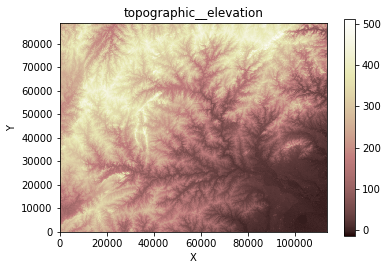

In [6]:
landlab.plot.imshow.imshow_grid_at_node(mg,'topographic__elevation') #mostra o DEM

### define boundary conditions

In [7]:
mg.BC_LINK_IS_FIXED
#mg.set_fixed_value_boundaries_at_grid_edges(right, top, left, bottom)
mg.set_fixed_value_boundaries_at_grid_edges(True, True, True, True)

## Create shear stress component

In [8]:
class Shear_Stress(Component): #classe do componente criado
    
    _name = "Shear_Stress"
    
    #parametros iniciais do objeto 
    def __init__(self, dem, fluid_density=1050, g=9.80665, runoff=1, k_Q=2.5e-07, c_sp=1, drain_area_threshold=None):
                        
        self._dem = dem
        self._runoff = runoff #The rate of excess overland flow production at each node (i.e.,rainfall rate less infiltration).
        self._k_Q = k_Q   # Prefactor on A**c_sp to give discharge.
        self._c_sp = c_sp # Power on drainage area to give discharge.
        self._g = g  #gravidade 
        self._drain_area_threshold = drain_area_threshold # Limiar da area de drenagem para ser considerado grao tipo 7
        self._fluid_density = fluid_density
        # profundidade:
        # node_Q = self._k_Q * self._runoff * node_A ** self._c_sp
        # pgd da formula do shear stress
        
    def discrete_shear_stress(self, ss): # divisao do shear stress para escala de tamnhos da escala de Roux (1998)
    
        if ss <= 0:
            return 0
        if ss <= 1:
            return 1
        if ss <= 1.2710:
            return 1.2710
        if ss <= 1.7423:
            return 1.7423
        if ss <= 2.1964:
            return 2.1964
        if ss <= 2.8541:
            return 2.8541
        if ss <= 6.6074:
            return 6.6074
        if ss <= 14.503:
            return 14.503
        if ss <= 29.138:
            return 29.138
        if ss <= 58.275:
            return 58.275

        return 60
    
    def get_size_grain(self, shear_stress):
        if shear_stress == 0:
            return 0.0031
        if shear_stress == 1:
            return 0.004
        if shear_stress == 1.2710:
            return 0.0063
        if shear_stress == 1.7423:
            return 0.0125
        if shear_stress == 2.1964:
            return 0.0250
        if shear_stress == 2.8541:
            return 0.0500
        if shear_stress == 6.6074:
            return 0.1
        if shear_stress == 14.503:
            return 0.2
        if shear_stress == 29.138:
            return 0.4
        if shear_stress == 58.275:
            return 0.8
        
        return 100
        
    
    def classify_grain(self, size):
        if size <= 0.004:
            return 1
        if size <= 0.062:
            return 2
        if size <= 0.25:
            return 3
        if size <= 0.5:
            return 4
        if size <= 1:
            return 5
        if size <= 4:
            return 6

        return 7
    
    def add_grid_to_dem(self, mg, name, value):
        if name in mg.at_node.keys():
            mg.delete_field("node",name)
                
        mg.add_field(name, value, at="node", copy=True, clobber=False)
        
    def calc_shear_stress(self, slope, profundidade):
        # pgd da formula do shear stress
        return self._fluid_density * self._g * profundidade * slope 
    
    # Area com baixo acumulo será arbitrariamente um grao tipo 7
    def update_drainage_area(self, da, treshold):
        _da = copy.copy(da)
        _da[_da < treshold] = 9999999
        return _da
         
        
    def run_one_step(self):
        dem = self._dem
        node_z = dem.at_node["topographic__elevation"] #elevaçao
        node_S = dem.at_node["topographic__steepest_slope"] #slope, vem do flow accumulator(?)
        
        if self._drain_area_threshold is None:
            node_A = dem.at_node["drainage_area"]
        else:
            node_A = self.update_drainage_area(dem.at_node["drainage_area"], treshold=self._drain_area_threshold)
        
        
        
        # profundidade
        node_Q = self._k_Q * self._runoff * node_A ** self._c_sp # Calcula profundidade, parte que tem a ver com PAR_1, PAR_2 
        #shear stress usando a profundidade
#         shear_stress_prefactor_timesAparts = (self._shear_stress_coeficient_p1 * node_Q ** self._shear_stress_coeficient_p2)
        counter=0
        
        while 1:
            
            #funçao clip atribui o valor zero a valores negativos que venham a ser encontrados
            #depressoes podem possuir valores negativos (lago, fosso, buraco negro)
            downward_slopes = node_S.clip(0.0) 
            slopes_tothe07 = downward_slopes ** 0.7 # nao sei pq
#             shear_stress = shear_stress_prefactor_timesAparts * slopes_tothe07 #multiplica o pre fator do shear stress pelo slope e calcula o shear stress
            shear_stress = self.calc_shear_stress(slopes_tothe07, node_Q)
            shear_stress_discrete = list(map(self.discrete_shear_stress, shear_stress)) #classifica os resultados anteriores com o intervalo definido
            
            grains_size = list(map(self.get_size_grain, shear_stress_discrete))
#             d50 = (node_Q * slopes_tothe07) / 0.05            
            grain_type = list(map(self.classify_grain, grains_size)) 
            
            #adiciona grid ao DEM
            self.add_grid_to_dem(dem, 'shear_stress', shear_stress)
            self.add_grid_to_dem(dem, 'shear_stress_discrete', shear_stress_discrete)
            self.add_grid_to_dem(dem, 'grain_type', grain_type)
                   
           
            
#             self.d = node_Q
#             self.S = slopes_tothe07
            
            break_flag = True
            if break_flag:
                    break
                    

## instantiate components

In [9]:
#fda = FlowAccumulator(mg, 'topographic__elevation') #cria o componente flow accumulator
css = Shear_Stress(mg) #cria o componente shear stress
fr = FlowAccumulator(mg, flow_director='D8') 
df = DepressionFinderAndRouter(mg)
sp = FastscapeEroder(mg, K_sp=0.001, m_sp=0.5, n_sp=1.0, threshold_sp= 0.0) #k eh erodibilidade, usar 0.0004
#FastscapeEroder(grid, K_sp=0.001, m_sp=0.5, n_sp=1.0, threshold_sp=0.0, discharge_field='drainage_area', erode_flooded_nodes=True)
ed = ErosionDeposition(
      mg,
      K=0.00001, # Erodibility for substrate (units vary)valor anterior = 0.00001
      v_s=0.001, # Effective settling velocity for chosen grain size metric [L/T].
      m_sp=0.5, # Discharge exponent (units vary) usar valores do fast scape (valor anterior = 0.5)
      n_sp = 1.0, #Slope exponent (units vary) usar valores do fast scape
      sp_crit=0) #Critical stream power to erode substrate [E/(TL^2)] usar valores do fast scape
#lin_diffuse = LinearDiffuser (mg, linear_diffusivity = 0.01)


## Run Components

In [11]:
uplift_rate = 0.0001
time_step = 100 
fr.run_one_step()
sp.run_one_step(time_step) # atençao: apenas para rodar antes do erosion deposition
for i in range(1):
    print(i)
    fr.run_one_step()
    df.map_depressions()
    #flooded = np.where(df.flood_status==3)[0] # ver pra que serve
    ed.run_one_step(time_step)
    mg.at_node['topographic__elevation'] += time_step * uplift_rate
    #no artigo ele usa em anos mas esta de acordo com todos os outros parametros em anos tbm 
#     lin_diffuse.run_one_step(time_step) 
    css.run_one_step()
    if i == 1000 or i == 500: #or i == 40 or i == 60 or i == 80 or i == 100:
        files = write_esri_ascii("./testes_dispersao/"+test_name+"/"+str(i)+".asc", mg)


0


In [50]:
(mg, z) = read_esri_ascii("./testes_dispersao/"+test_name+"/1000_grain_type.asc", name='grain_type')
(mg_100, z) = read_esri_ascii("./testes_dispersao/"+test_name+"/500_grain_type.asc", name='grain_type')
# mg.at_node.keys()#lista os grids contidos no DEM

In [41]:
(mg, z) = read_esri_ascii("./testes_dispersao/dispersao_sem_ed/100_grain_type.asc", name='grain_type')
# mg.at_node.keys()#lista os grids contidos no DEM

FileNotFoundError: [Errno 2] No such file or directory: './testes_dispersao/dispersao_sem_ed/1000_grain_type.asc'

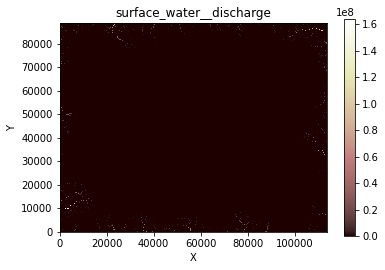

In [19]:
landlab.plot.imshow.imshow_grid_at_node(mg, 'surface_water__discharge')

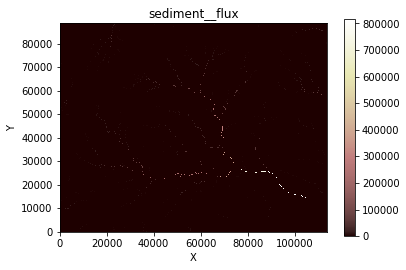

In [18]:
landlab.plot.imshow.imshow_grid_at_node(mg, 'sediment__flux')


In [21]:
#d = qs * (vs / q)

vs = 1
qs = mg.at_node["sediment__flux"]
q = mg.at_node["surface_water__discharge"]

d = qs* (vs / q)

/home/joker/.virtualenvs/geo/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/home/joker/.virtualenvs/geo/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


In [35]:
mg.add_field("deposition_rate", d, at="node", copy=True, clobber=False)

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

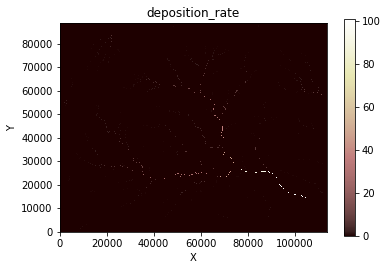

In [37]:
landlab.plot.imshow.imshow_grid_at_node(mg, 'deposition_rate')

In [69]:
da = mg.at_node['drainage_area']
len(da[da == 0]), len(da)

(3386, 1250529)

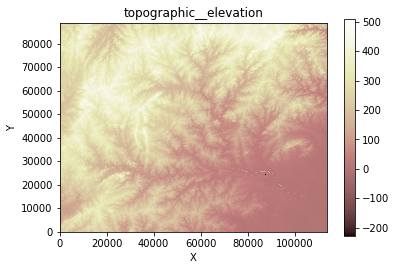

In [52]:
(mg, z) = read_esri_ascii("./testes_dispersao/ed_time_step_10/10_topographic__elevation.asc", name="topographic__elevation")
mg.at_node.keys()#lista os grids contidos no DEM
landlab.plot.imshow.imshow_grid_at_node(mg, 'topographic__elevation')

## Plot

> https://www.geodose.com/2019/09/3d-terrain-modelling-in-python.html

>https://stackoverflow.com/questions/33287620/creating-a-smooth-surface-plot-from-topographic-data-using-matplotlib

In [77]:
from scipy.interpolate import griddata

In [89]:
v = mg.at_node['topographic__elevation'].reshape(987, 1267)
lines, col = v.shape 


X = np.array(list(range(lines)))
Y = np.array(list(range(lines)))

Z = np.rint(z[0:lines])

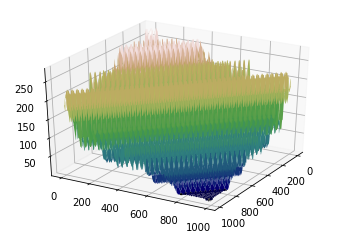

In [126]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.view_init(30, 30)

step = int((len(Z)/3))
xi = np.linspace(X.min(),X.max(),step)
yi = np.linspace(Y.min(),Y.max(),step)
zi = griddata((X, Y), Z, (xi[None,:], yi[:,None]), method='nearest')

xig, yig = np.meshgrid(xi, yi)

ax.plot_surface(xig, yig, zi, cmap='gist_earth')


## Plot results

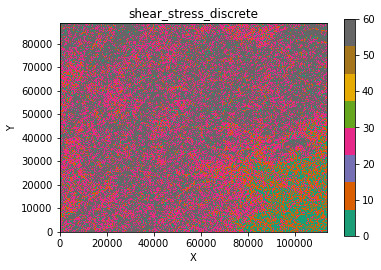

In [65]:
landlab.plot.imshow.imshow_grid_at_node(mg,'shear_stress_discrete', cmap='Dark2')

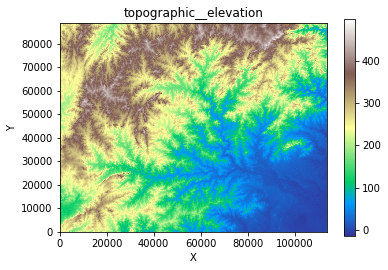

In [66]:
landlab.plot.imshow.imshow_grid_at_node(mg,'topographic__elevation', cmap='terrain')

## Run again

In [67]:
fda.run_one_step()
sp.run_one_step(dt=100000)
css.run_one_step() #dt em anos

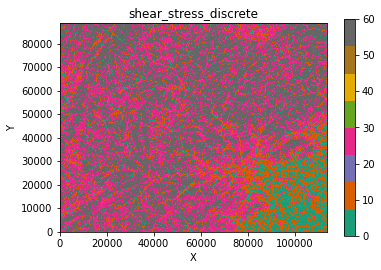

In [68]:
landlab.plot.imshow.imshow_grid_at_node(mg,'shear_stress_discrete', cmap='Dark2')

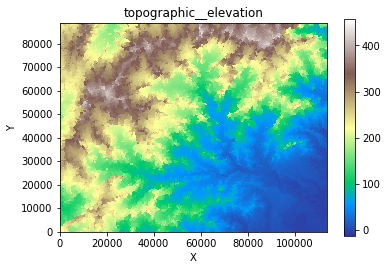

In [69]:
landlab.plot.imshow.imshow_grid_at_node(mg,'topographic__elevation', cmap='terrain')